In [1]:
import io
import urllib
import lxml
import lxml.html
import lxml.html.soupparser
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn
import scipy
from datetime import datetime, timedelta
import datetime
import time
%matplotlib inline

//anaconda/envs/mypy27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
boro_ymd_df = pd.read_csv('by_boro_ymd.out', header=None)
boro_ymd_df = boro_ymd_df.rename(index=str, columns={0: 'boro', 1: 'year', 2: 'month', 3: 'day', 4: 'crimes'})
boro_ymd_df.boro = boro_ymd_df.boro.str.strip(to_strip = "(").str.strip(to_strip = "'")
boro_ymd_df.year = pd.to_numeric(boro_ymd_df.year.str.strip().str.strip(to_strip = '('))
boro_ymd_df.month = pd.to_numeric(boro_ymd_df.month)
boro_ymd_df.day = pd.to_numeric(boro_ymd_df.day.str.strip(to_strip = ")"))

boro_ymd_df = boro_ymd_df[boro_ymd_df.year >= 2006]
boro_ymd_df = boro_ymd_df[boro_ymd_df.day >= 1]

boro_ymd_df.crimes = pd.to_numeric(boro_ymd_df.crimes.str.strip(to_strip = ")"))
boro_ymd_df['ymd'] = pd.to_datetime((boro_ymd_df.year*10000+boro_ymd_df.month*100+boro_ymd_df.day).apply(str),format='%Y%m%d')
table_boros_ymd = boro_ymd_df.pivot_table(values='crimes', index=['ymd'], columns=['boro'], aggfunc=np.sum)
table_boros_ymd.drop('', inplace=True, axis = 1)
table_boros_ymd = table_boros_ymd.fillna(0)
table_boros_ymd.head()

boro,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
ymd,,,,,
2006-01-01,414.0,664.0,519.0,433.0,121.0
2006-01-02,245.0,382.0,242.0,273.0,69.0
2006-01-03,335.0,406.0,306.0,274.0,63.0
2006-01-04,343.0,452.0,358.0,303.0,70.0
2006-01-05,367.0,459.0,408.0,287.0,82.0


In [4]:
table_boros_ymd.shape

(3652, 5)

In [3]:
def get_weather(date):
    baseurl = 'https://www.wunderground.com/history/airport/KNYC/{}/{}/{}/DailyHistory.html'
    tag_regex = re.compile(r'<.+>([0-9.,]+)<\/.+>')

    temperature = np.nan
    humidity = np.nan
    precip = np.nan
    snow = np.nan
    wind = np.nan

    year = pd.to_datetime(str(date)).year
    month = pd.to_datetime(str(date)).month
    day = pd.to_datetime(str(date)).day

    r = requests.get(baseurl.format(year, month, day)).text
    soup = BeautifulSoup(r, 'lxml')

    temperature_tag = soup.find('span', string='Mean Temperature')
    if temperature_tag:
        temperature_tag = temperature_tag.find_next(class_='wx-value')
    humidity_tag = soup.find('span', string='Average Humidity')
    if humidity_tag:
        humidity_tag = humidity_tag.find_next('td')
    precip_tag = soup.find('span', string='Precipitation')
    if precip_tag:
        precip_tag = precip_tag.find_next(class_='wv-value')
    snow_tag = soup.find('span', string='Snow')
    if snow_tag:
        snow_tag = snow_tag.find_next(class_='wx-value')
    wind_tag = soup.find('span', string='Max Wind Speed')
    if wind_tag:
        wind_tag = wind_tag.find_next(class_='wx-value')

    match = re.search(tag_regex, str(temperature_tag))
    if match:
        temperature = float(match.group(1))
    match = re.search(tag_regex, str(humidity_tag))
    if match:
        humidity = float(match.group(1))
    match = re.search(tag_regex, str(precip_tag))
    if match:
        precip = float(match.group(1))
    match = re.search(tag_regex, str(snow_tag))
    if match:
        snow = float(match.group(1))
    match = re.search(tag_regex, str(wind_tag))
    if match:
        wind = float(match.group(1))

    return temperature, humidity, precip, snow, wind

In [9]:
from tqdm import tqdm 
import time

nrows = len(table_boros_ymd)
temp = [np.nan]*nrows
humidity = [np.nan]*nrows
precip = [np.nan]*nrows
snow = [np.nan]*nrows
wind = [np.nan]*nrows
inds = [np.nan]*nrows


for i in tqdm(range(nrows)):
    # Keep track of progress

    
    # Scrape in a try-except block and move onto next row if can't scrape successfully
    try:
        temp[i], humidity[i], precip[i], snow[i], wind[i] = get_weather(table_boros_ymd.index[i])
    except:
        continue

    inds[i] = i

    if i+1 % 100 == 0: # Save intermediate results every 100 rows
        weather_df = pd.DataFrame({'temp': temp, 'humidity': humidity, 'precipitation': precip, 'snowfall': snow, 'max wind speed': wind}, index=inds)
        weather_df.to_csv('weather_CentralPark_partial.csv')

weather_df = pd.DataFrame({'temp': temp, 'humidity': humidity, 'precipitation': precip, 'snowfall': snow, 'max wind speed': wind})
weather_df.head(10)
weather_df.to_csv('weather_CentralPark06to15.csv')

100%|██████████| 3652/3652 [55:07<00:00,  1.11it/s]    | 1/3652 [00:00<55:55,  1.09it/s]


In [20]:
weather_df.index = table_boros_ymd.index
weather_df.drop('precipitation', inplace=True, axis = 1)
weather_df.to_csv('weather_CentralPark06to15.csv')
weather_df.describe()

,humidity,max wind speed,snowfall,temp
count,3650.000000,3640.000000,3503.000000,3652.000000
mean,61.647397,14.377198,0.092806,56.135816
std,14.464131,4.334436,0.815673,17.175609
min,20.000000,3.000000,0.000000,11.000000
25%,51.000000,12.000000,0.000000,42.000000
50%,61.000000,14.000000,0.000000,57.000000
75%,72.000000,16.000000,0.000000,71.000000
max,97.000000,99.000000,24.100000,94.000000


In [21]:
table_boros_ymd_weather = table_boros_ymd.merge(weather_df, left_index=True, right_index=True)

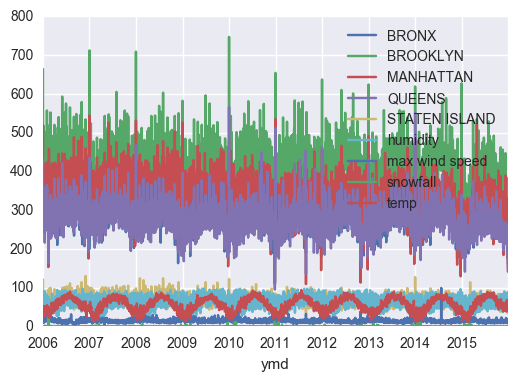

In [23]:
table_boros_ymd_weather.plot()